<a href="https://colab.research.google.com/github/yovahn/Carla/blob/master/scripts/basic_lane_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pathlib import Path
import os
import numpy as np
img_folder = Path('/content/imgs')
img_list = list(img_folder.glob('**/*.png'))
print(img_list)

[PosixPath('/content/imgs/00004948.png'), PosixPath('/content/imgs/00005091.png'), PosixPath('/content/imgs/00005066.png'), PosixPath('/content/imgs/00005086.png'), PosixPath('/content/imgs/00004937.png'), PosixPath('/content/imgs/00005014.png'), PosixPath('/content/imgs/00004959.png'), PosixPath('/content/imgs/00005002.png'), PosixPath('/content/imgs/00005065.png'), PosixPath('/content/imgs/00004902.png'), PosixPath('/content/imgs/00005027.png'), PosixPath('/content/imgs/00004926.png'), PosixPath('/content/imgs/00005053.png'), PosixPath('/content/imgs/00004980.png'), PosixPath('/content/imgs/00004913.png'), PosixPath('/content/imgs/00004991.png'), PosixPath('/content/imgs/00005041.png'), PosixPath('/content/imgs/00004891.png'), PosixPath('/content/imgs/00004969.png'), PosixPath('/content/imgs/00005015.png'), PosixPath('/content/imgs/00004925.png'), PosixPath('/content/imgs/00005089.png'), PosixPath('/content/imgs/00004970.png'), PosixPath('/content/imgs/00004903.png'), PosixPath('/con

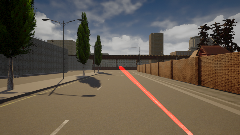

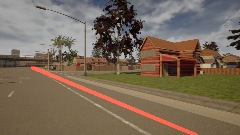

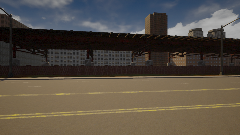

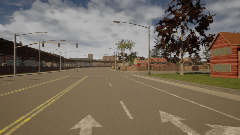

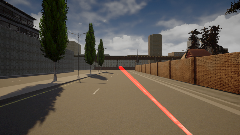

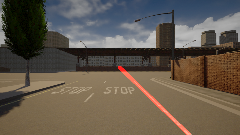

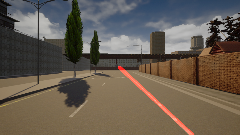

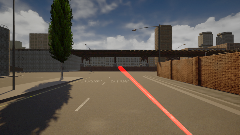

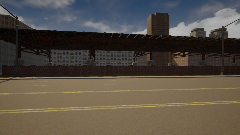

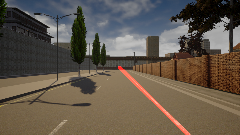

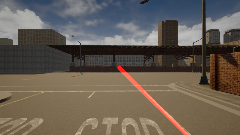

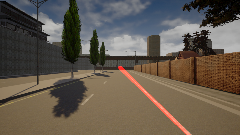

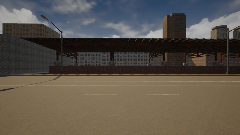

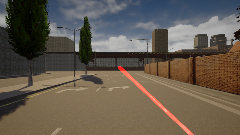

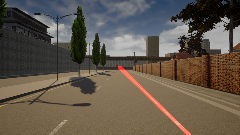

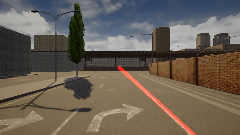

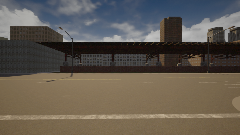

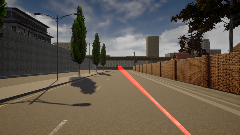

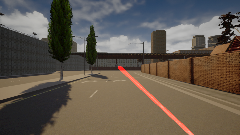

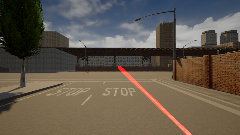

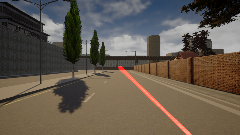

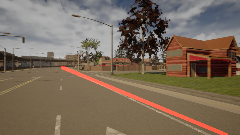

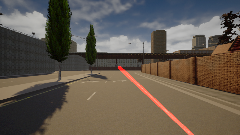

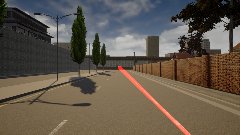

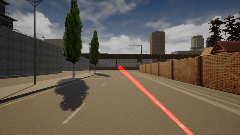

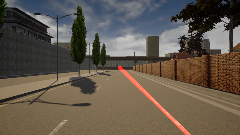

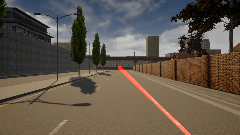

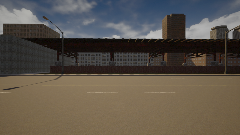

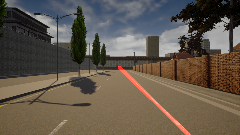

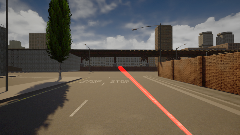

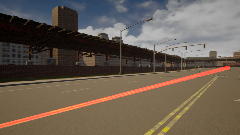

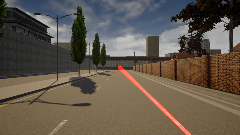

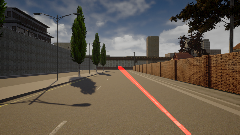

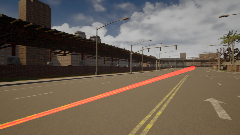

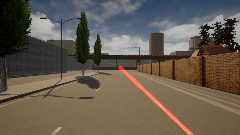

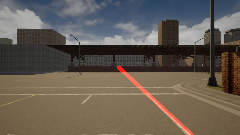

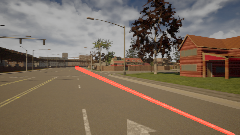

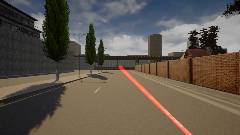

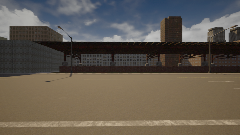

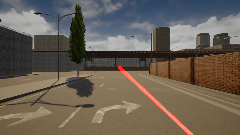

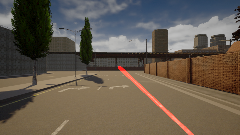

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread(os.fspath(img_list[0]))

def find_street_lanes(image):
  gray = grayscale(image)
  blur_img = blur(gray)
  canny_image = canny(blur_img)
  roi_image = roi(canny_image)
  hough_lines_image = hough_lines(roi_image, 2, np.pi/180, 150, 100, 5)
  final_image = combine_images(hough_lines_image, image)
  return final_image

for path in img_list:
  try:
    image = cv2.imread(os.fspath(path))
    output = find_street_lanes(image)
    cv2_imshow(cv2.resize(output, (240, 135)))
  except:
    pass


In [ ]:

def find_street_lanes(image):
    grayscale_image = grayscale(image)
    blur_image = blur(grayscale_image)
    canny_image = canny(blur_image)
    roi_image = roi(canny_image)
    hough_lines_image = hough_lines(roi_image, 0.9, np.pi/180, 100, 40, 5)
    final_image = combine_images(hough_lines_image, image)


In [ ]:
def grayscale(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return gray

def blur(image):
  blur_image = cv2.GaussianBlur(image, (3,3),0)
  return blur_image

def canny(image):
  canny_image = cv2.Canny(image, 100, 150)
  return canny_image

def roi(image):
  bottom_padding = 100 # Front bumper compensation
  height = image.shape[0]
  width = image.shape[1]
  bottom_left = [width*1/4, height-bottom_padding]
  bottom_right = [width*3/4, height-bottom_padding]
  top_right = [width*1/2, height*1/2]
  top_left = [width*1/2, height*1/2]
  vertices = [np.array([bottom_left, bottom_right, top_left, top_right], dtype=np.int32)]
  mask = np.zeros_like(image)  
  cv2.fillPoly(mask, vertices, 255)
  masked_image = cv2.bitwise_and(image, mask)
  return masked_image

def averaged_lines(image, lines):
    right_lines = []
    left_lines = []
    for x1,y1,x2,y2 in lines[:, 0]:
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope >= 0: 
            right_lines.append([slope, intercept])
        else:
            left_lines.append([slope, intercept])
            
    def merge_lines(image, lines):
        if len(lines) > 0:
            slope, intercept = np.average(lines, axis=0)
            y1 = image.shape[0]
            y2 = int(y1*(1/2))
            x1 = int((y1 - intercept)/slope)
            x2 = int((y2 - intercept)/slope)
            return np.array([x1, y1, x2, y2])
        
    left = merge_lines(image, left_lines)
    right = merge_lines(image, right_lines)
    return left, right


def hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    lines_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is not None:
        lines = averaged_lines(image, lines)
        for line in lines:
            if line is not None:
                x1,y1,x2,y2 = line
                cv2.line(lines_image, (x1, y1), (x2, y2), (0, 0, 255), 20)
    return lines_image

def combine_images(image, initial_image, α=0.9, β=1.0, λ=0.0):
    combined_image = cv2.addWeighted(initial_image, α, image, β, λ)
    return combined_image

